# Autoencoder Convolucional GOA - One layer

Complementamos el estudio de GOA, entrenando un modelo convolucional que utiliza imágenes de gráficos polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ - calculada utilizando la aproximación GOA sobre un modelo de una capa rugosa. El input del modelo convolucional es un tensor de 30x30x4, que contiene las imagenes de la potencia dispersada en los canales  HH, HV, VH y VV.

## Cargamos los modelos de scattering y generamos los datos



In [10]:
import integrals
from goa import *

In [11]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

# Parámetros fijos
realizations = 20000

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/np.linspace(.05, .3, 50)
epsilon = np.arange(3, 53)
rms_high =  np.linspace(.005, .025, 50)
corr_len =  np.linspace(.05, .25, 50)
theta_i, phi_i = np.linspace(1e-5, 89, 50)*np.pi/180, np.linspace(0, 180, 50)*np.pi/180 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi/180, np.linspace(0, 360, 30)*np.pi/180 
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigmas = np.zeros((realizations, PHI.shape[0], PHI.shape[1], 4))


for i in range(realizations):
  # Genero una tira de indices aleatorios
  index = rng.integers(50, size=6)
  
  # Armo una tupla con los argumentos de S01     
  args = (k0[index[0]], theta_i[index[1]], phi_i[index[2]],
          THETA, PHI,
          epsilon[index[3]])

  # Calculo la sección eficaz y agrego ruido
  vectors = wave_vectors(*args)
  pdf = slopes_prob_density(vectors, rms_high[index[4]], corr_len[index[5]])
  fresnel = local_fresnel_coefficients(vectors, args[-1])
  pol = global_polarization_vectors(*args[1:5])
  shadow = shadowing(*args[1:5], rms_high[index[4]], corr_len[index[5]])
  amps = alternative_amplitudes(vectors, pol, fresnel)
  S = sigma(vectors, pdf['reflected'], amps, shadow)

  # v-pol
  s_vv = S['vv']
  s_vv_noise = s_vv + rng.normal(0, .03*np.mean(s_vv), size = PHI.shape)

  s_vh = S['vh']
  s_vh_noise = s_vh + rng.normal(0, .03*np.mean(s_vh), size = PHI.shape)

  # h-pol
  s_hh = S['hh']
  s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size = PHI.shape)

  s_hv = S['hv']
  s_hv_noise = s_hv + rng.normal(0, .03*np.mean(s_hv), size = PHI.shape)

  # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
  cond = np.count_nonzero(np.isnan(s_hh_noise))              # Cuenta cantidad de NaNs
  if cond == 0: 
    stack = np.dstack((s_hh_noise/np.max(np.abs(s_hh_noise)),
                      s_hv_noise/np.max(np.abs(s_hv_noise)),
                      s_vh_noise/np.max(np.abs(s_vh_noise)), 
                      s_vv_noise/np.max(np.abs(s_vv_noise))))
    sigmas[i,:,:,:] = stack
  else:
    raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')


In [12]:
# Chequeo el tamaño de los datos
shape = sigmas.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (20000, 30, 30, 4)


## Visualizo las soluciones generadas

(-1.0, 1.0)

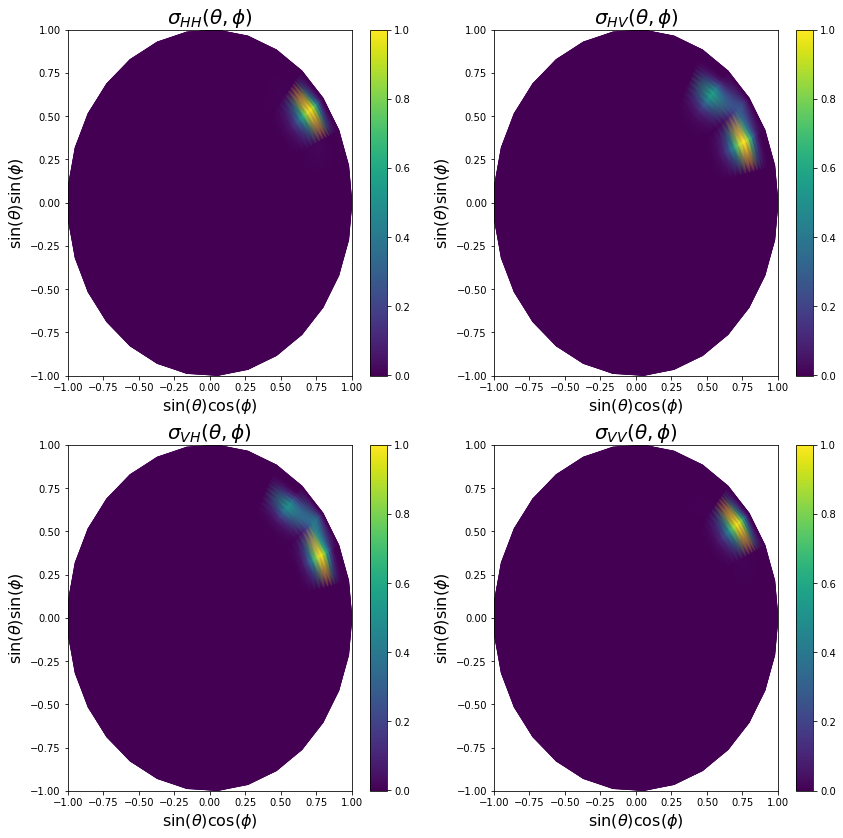

In [13]:
index = rng.integers(shape[0]) 
img = sigmas[index,:,:,:]


fig = plt.figure(figsize=(14, 14))
# Canal HH
ax = plt.subplot(2, 2, 1)
c = ax.pcolormesh(kx, ky, sigmas[index,:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal HV
ax = plt.subplot(2, 2, 2)
c = ax.pcolormesh(kx, ky, sigmas[index,:,:,1],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VH
ax = plt.subplot(2, 2, 3)
c = ax.pcolormesh(kx, ky, sigmas[index,:,:,2],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(2, 2, 4)
c = ax.pcolormesh(kx, ky, sigmas[index,:,:,3],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

## Preparo los datos y defino el Autoencoder

In [14]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigmas))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigmas, test_size=.2)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (16000, 30, 30, 4)
Tamaño de los datos de testeo: (4000, 30, 30, 4)


Visualizo los elementos del conjuto de entrenamiento

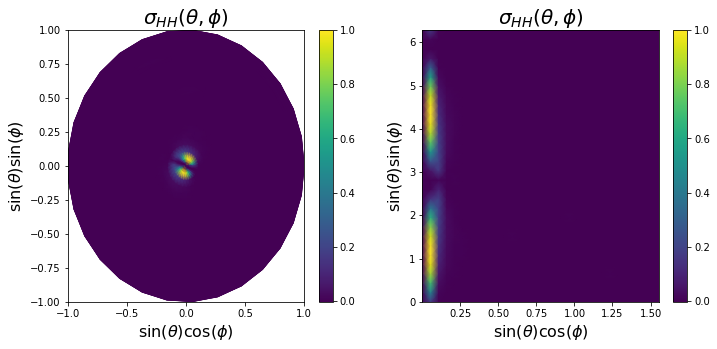

In [15]:
index = rng.integers(sigma_test.shape[0]) 
img = sigma_test[index,:,:,:]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(THETA, PHI, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,4)), 
                                            layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            layers.Conv2D(16, (3, 3), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            layers.Flatten(),
                                            layers.Dense(units = 18*18*16, activation = 'relu'),
                                            layers.Dense(units = 512, activation = 'relu'),
                                            layers.Dense(units = 64, activation = 'relu'),
                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                            layers.Dense(units = 64, activation = 'relu'),
                                            layers.Dense(units = 512, activation = 'relu'),
                                            layers.Dense(units = 18*18*16, activation = 'relu'),
                                            
                                            layers.Reshape(target_shape=(18,18,16)),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(4, (7, 7), strides=1, activation ='relu'),
                                            layers.Conv2D(4, (4, 4), activation="sigmoid", padding="same")])
    
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

2022-03-18 18:43:23.862023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 18:43:23.862090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
autoencoder = ConvAutoencoder(3)
autoencoder.build(input_shape = (16000,30,30,4))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 4)         788       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        1168      
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 5184)              2

In [26]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 150,
            batch_size = 64,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()
plt.show()

In [19]:
# Guardamos los pesos de la red entrenada
import os
file_name= 'results/weights_lat_8_goa_one_layer.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
print(os.path.isdir(os.path.join("/".join(folder), "results")))
#autoencoder.save_weights(weights_path)

True


# Visualizamos los resultados 

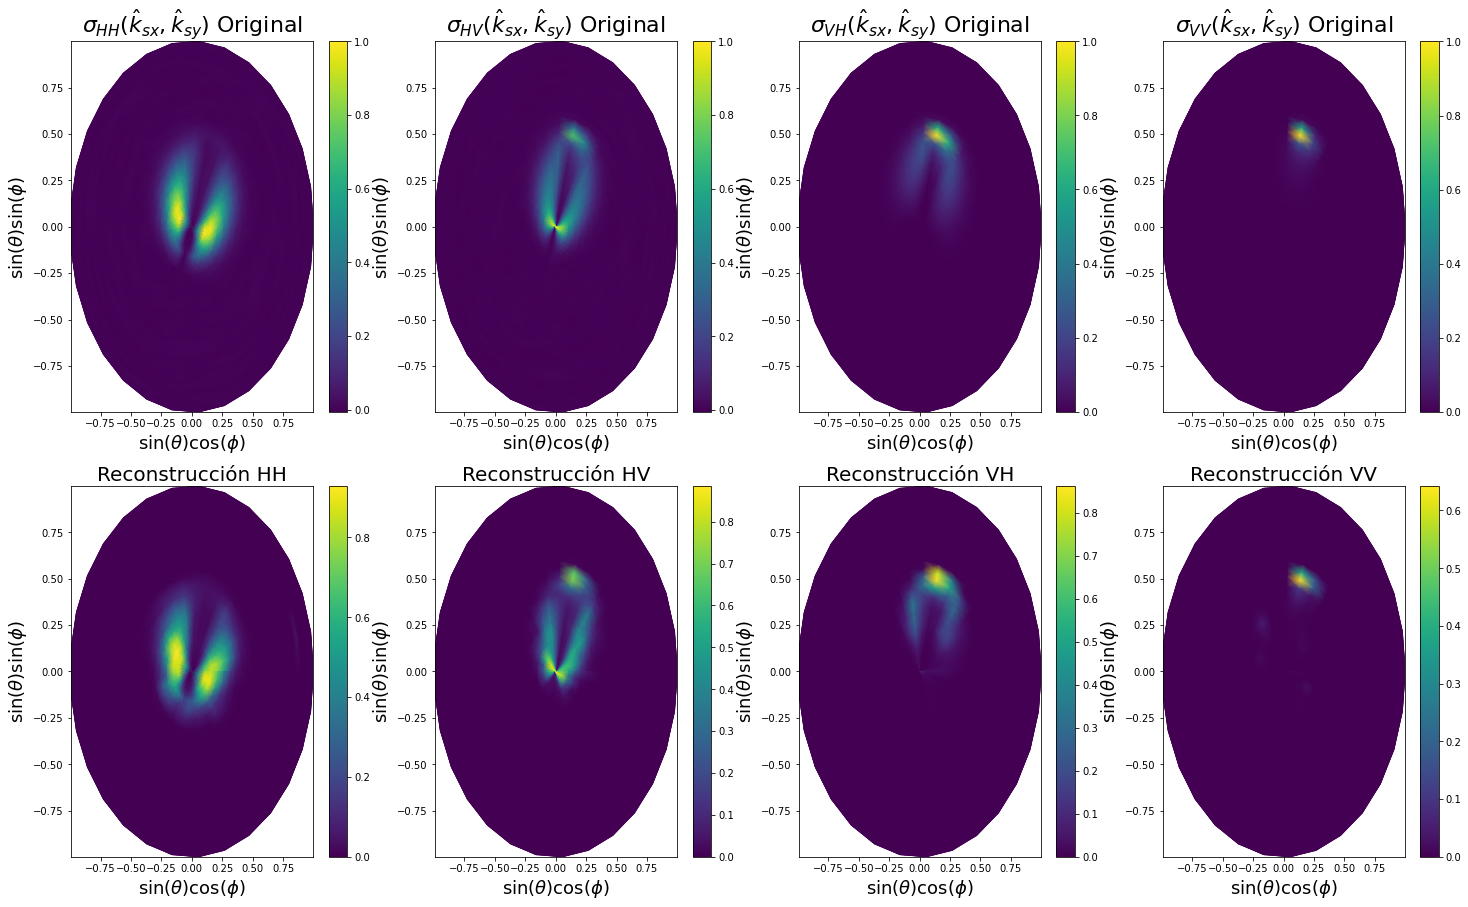

In [20]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(sigma_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 4
pol = {0: "HH", 1: "HV", 2: "VH", 3: "VV"}
index = rng.integers(sigma_test.shape[0])

fig=plt.figure(figsize=(25, 15)) 
for i in range(n):
    # Imagen original
    s = sigma_test[index, :, :, i]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, i]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()

In [21]:
# Libero espacio en memoria
tf.keras.backend.clear_session()
del autoencoder

## Variamos la dimensión del Espacio Latente

In [22]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 150,
            batch_size = 64,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 50 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  # Elimino el modelo de la memoria
  tf.keras.backend.clear_session()
  del autoencoder

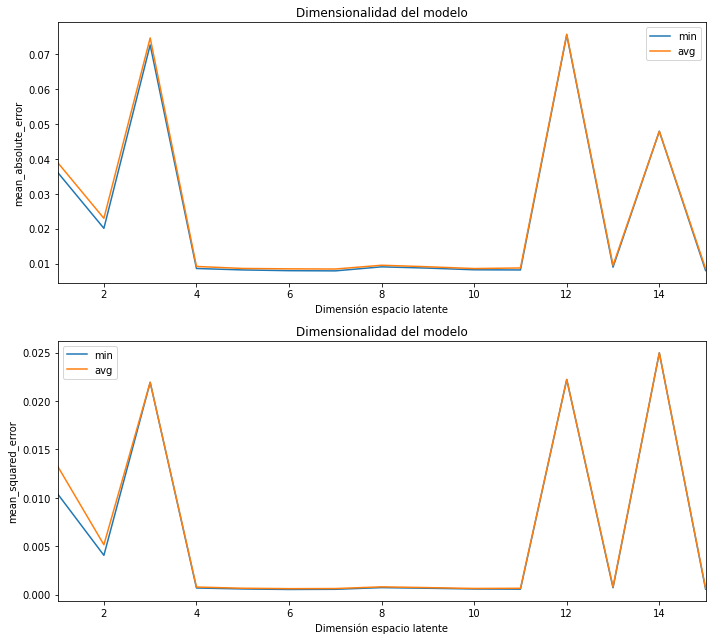

In [23]:
img_name= 'results/costo_GOA_one_layer.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [24]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_GOA_one_layer.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)